In [1]:
# core
import pandas as pd
import numpy as np
import sys
import joblib

# Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# Feature Selection
from scipy.stats import spearmanr, chi2_contingency
from sklearn.feature_selection import mutual_info_classif

# Data Preparation utils
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)
from utils.data_preparation import cleaning, create_geoclusters, feature_engineering, encoding, scaling
from utils.preprocess_pipeline import PreprocessTransformer
from sklearn.pipeline import Pipeline

# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, fbeta_score
from imblearn.over_sampling import SMOTE

# LightGBM Model
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import shap


<div class="alert alert-block alert-success">
<a id='explore'>
<font color = '#000000'>
    
# **1. Feature Selection**</font>
</a>

#### 1.1. Dealing with multicolinearity

In [2]:
# load train_scaled.parquet
train_scaled = pd.read_parquet(
    "../data/intermediate_dfs/train_scaled.parquet",
    engine="pyarrow"
)

In [3]:
# see all columns
pd.set_option('display.max_columns', None)
corr_matrix = train_scaled.corr(method='spearman')
corr_matrix.head(2)

,Senior Citizen,Married,Dependents,Tenure in Months,Phone Service,Internet Type,Avg Monthly GB Download,Unlimited Data,Paperless Billing,Monthly Charge,Churn Value,Total Charges per Month,Total Refunds per Month,Total Extra Data Charges per Month,Total Long Distance Charges per Month,Total Revenue per Month,Number of Referrals_bins,GeoCluster,Streaming Services,Value Added Services,Payment Method_Credit Card,Payment Method_Mailed Check,Contract Duration,Male
Senior Citizen,1.000000,0.032543,-0.176821,0.026257,0.152408,0.267078,-0.014620,0.134219,0.148612,0.236317,0.136332,0.232749,0.054517,0.049347,0.014511,0.203865,0.008607,0.027977,0.129221,0.076952,-0.123204,-0.053122,0.040555,0.012973
Married,0.032543,1.000000,0.363256,0.390166,0.146919,0.022155,0.058781,0.018688,-0.008265,0.126315,-0.143091,0.123120,0.020954,-0.005885,0.021288,0.102806,0.908197,0.012232,0.127386,0.127430,0.017807,-0.076221,0.276861,0.000187


In [4]:
# Extracting strong associations
threshold = 0.6

strong_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack().reset_index())

strong_pairs.columns = ['var1', 'var2', 'association']

strong_pairs = strong_pairs[
    (strong_pairs['association'] > threshold) |
    (strong_pairs['association'] < -threshold)
]

strong_pairs.sort_values('association', ascending=False)

,var1,var2,association
172,Monthly Charge,Total Charges per Month,0.991412
37,Married,Number of Referrals_bins,0.908197
201,Total Charges per Month,Total Revenue per Month,0.892291
176,Monthly Charge,Total Revenue per Month,0.888089
108,Internet Type,Monthly Charge,0.867860
110,Internet Type,Total Charges per Month,0.864348
114,Internet Type,Total Revenue per Month,0.772255
179,Monthly Charge,Streaming Services,0.711635
204,Total Charges per Month,Streaming Services,0.710069
84,Tenure in Months,Contract Duration,0.649941


We will later take into consideration thse pairs of related_variables, droping whenever possible one feature per pair from training because are highly related and can generate multicolinearity issues.

We will define the features to drop after performing subsequent analysis on features' relevance.

#### 1.2. Understanding Feature Relevance

In [5]:
# split data into X and Y
X = train_scaled.drop(columns=["Churn Value"])
print(f"X.shape: {X.shape}")
Y = train_scaled["Churn Value"]
print(f"Y.shape: {Y.shape}")

X.shape: (4225, 23)
Y.shape: (4225,)


##### 1.2.1. Mutual Information

In [6]:
mi = mutual_info_classif(X, Y, random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
# print all scores
print("Mutual Information Scores:")
print("-----------------------")
print(mi_series.round(3))

Mutual Information Scores:
-----------------------
Contract Duration                        0.112
Tenure in Months                         0.073
Number of Referrals_bins                 0.059
Monthly Charge                           0.050
Internet Type                            0.050
Avg Monthly GB Download                  0.038
Total Charges per Month                  0.036
Payment Method_Credit Card               0.028
Paperless Billing                        0.024
Total Revenue per Month                  0.018
Married                                  0.015
Dependents                               0.015
Unlimited Data                           0.014
Senior Citizen                           0.012
Total Extra Data Charges per Month       0.010
Value Added Services                     0.006
Total Refunds per Month                  0.006
Total Long Distance Charges per Month    0.004
Payment Method_Mailed Check              0.003
GeoCluster                               0.003
Phone Ser

##### 1.2.2. Correlation

In [7]:
def correlation_ratio(categories, values):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg = np.mean(values)

    numerator = 0
    denominator = 0

    for i in range(cat_num):
        cat_values = values[fcat == i]
        if len(cat_values) > 0:
            numerator += len(cat_values) * (np.mean(cat_values) - y_avg) ** 2

    denominator = np.sum((values - y_avg) ** 2)
    if denominator == 0:
        return 0

    return numerator / denominator

In [8]:
corr_ratios = {}

for col in X.columns:
    corr_ratios[col] = correlation_ratio(X[col], Y)

corr_ratios = pd.Series(corr_ratios).sort_values(ascending=False)
corr_ratios = corr_ratios.round(3)
print(corr_ratios)

Total Revenue per Month                  0.992
Total Charges per Month                  0.951
Total Long Distance Charges per Month    0.652
Monthly Charge                           0.405
Contract Duration                        0.218
Tenure in Months                         0.148
Number of Referrals_bins                 0.108
Internet Type                            0.094
Total Refunds per Month                  0.071
Avg Monthly GB Download                  0.070
Total Extra Data Charges per Month       0.065
Dependents                               0.056
Payment Method_Credit Card               0.047
Paperless Billing                        0.037
Unlimited Data                           0.030
Married                                  0.020
Senior Citizen                           0.019
Streaming Services                       0.016
GeoCluster                               0.007
Payment Method_Mailed Check              0.003
Value Added Services                     0.003
Phone Service

##### 1.2.3. Feature Selection

In [9]:
# --- 1. Score MI values ---
mi_df = mi_series.to_frame(name="MI")

mi_df["MI_score"] = pd.cut(
    mi_df["MI"],
    bins=[-np.inf, 0.01, 0.05, np.inf],
    labels=[0, 1, 2]
).astype(int)


# --- 2. Score correlation ratio values ---
corr_df = corr_ratios.to_frame(name="CorrRatio")

corr_df["Corr_score"] = pd.cut(
    corr_df["CorrRatio"],
    bins=[-np.inf, 0.2, 0.4, np.inf],
    labels=[0, 1, 2]
).astype(int)


# --- 3. Combine into one table ---
combined = mi_df.join(corr_df, how="outer")

# if any feature is missing, give score 0
combined[["MI_score", "Corr_score"]] = combined[["MI_score", "Corr_score"]].fillna(0).astype(int)

combined["TotalScore"] = combined["MI_score"] + combined["Corr_score"]

combined = combined.sort_values("TotalScore", ascending=False)

pd.set_option('display.max_colwidth', None)
display(combined.round(3))

,MI,MI_score,CorrRatio,Corr_score,TotalScore
Monthly Charge,0.050,2,0.405,2,4
Total Charges per Month,0.036,1,0.951,2,3
Contract Duration,0.112,2,0.218,1,3
Total Revenue per Month,0.018,1,0.992,2,3
Tenure in Months,0.073,2,0.148,0,2
Total Long Distance Charges per Month,0.004,0,0.652,2,2
Number of Referrals_bins,0.059,2,0.108,0,2
Internet Type,0.050,2,0.094,0,2
Married,0.015,1,0.020,0,1
Total Extra Data Charges per Month,0.010,1,0.065,0,1


We will immediatelly drop some features that are belong to pairs of variables highly related to each other (as analyzed in 1.2.). We will choose the variable to drop based on their relative importance and business interpretability.

In [10]:
# variables to drop due to correlation analysis
related_variables = [
    'Total Charges per Month', 'Total Revenue per Month', # highly correlated with 'Monthly Charge'
    'Married', # highly correlated with referrals info but with less importance
    'Avg Monthly GB Download', # less actionable and related info is already captured by 'Total Extra Data Charges per Month' and 'Unlimited Data'
]

Now we can define the final sublists of variables that we will use for modelling.

In [11]:
# create two lists of varibles considering their importance based on the correlation and MI analysis

important_variables = (
    combined[combined['TotalScore'] >= 1]
    .sort_values('TotalScore', ascending=False)
    .index
    .difference(related_variables)   # remove related variables
    .tolist()
)

print(f"important_variables lenght: {len(important_variables)}")
print(f"important_variables: {important_variables}")

print("---")

all_variables = [
    c for c in train_scaled.columns
    if c not in related_variables and c != 'Churn Value' # remove related variables and churn value (target)
]

print(f"other_variables lenght: {len(all_variables)}")
print(f"other_variables: {all_variables}")

important_variables lenght: 12
important_variables: ['Contract Duration', 'Dependents', 'Internet Type', 'Monthly Charge', 'Number of Referrals_bins', 'Paperless Billing', 'Payment Method_Credit Card', 'Senior Citizen', 'Tenure in Months', 'Total Extra Data Charges per Month', 'Total Long Distance Charges per Month', 'Unlimited Data']
---
other_variables lenght: 19
other_variables: ['Senior Citizen', 'Dependents', 'Tenure in Months', 'Phone Service', 'Internet Type', 'Unlimited Data', 'Paperless Billing', 'Monthly Charge', 'Total Refunds per Month', 'Total Extra Data Charges per Month', 'Total Long Distance Charges per Month', 'Number of Referrals_bins', 'GeoCluster', 'Streaming Services', 'Value Added Services', 'Payment Method_Credit Card', 'Payment Method_Mailed Check', 'Contract Duration', 'Male']


In [12]:
# create function to select only cols that belong to 'important_variables' list
def select_important_variables(df):
    important_variables = [
        'Contract Duration', 'Dependents', 'Internet Type', 'Monthly Charge', 'Number of Referrals_bins', 'Paperless Billing', 
        'Payment Method_Credit Card', 'Senior Citizen', 'Tenure in Months', 'Total Extra Data Charges per Month', 
        'Total Long Distance Charges per Month', 'Unlimited Data'] + ['Churn Value']

    return df[important_variables]

<div class="alert alert-block alert-success">
<a id='explore'>
<font color = '#000000'>
    
# **2. Modelling**</font>
</a>

In [13]:
# load from initial_dfs the train_df.parquer as train_df and the val_df.parquet as val_df
train_df = pd.read_parquet(
    "../data/initial_dfs/train_df.parquet",
    engine="pyarrow"
)

print(f"train_df.shape: {train_df.shape}")

val_df = pd.read_parquet(
    "../data/initial_dfs/val_df.parquet",
    engine="pyarrow"
)

print(f"val_df.shape: {val_df.shape}")

train_df.shape: (4225, 52)
val_df.shape: (1409, 52)


In [14]:
# Split raw X and Y

TARGET = "Churn Value"

X_train = train_df.drop(columns=[TARGET])
Y_train = train_df[TARGET].astype(int)

X_val = val_df.drop(columns=[TARGET])
Y_val = val_df[TARGET].astype(int)

### 2.1. BASELINE - Zero fine-tune Logistic Regression model

In [15]:
# Build Pipeline for preprocess and model
pipe = Pipeline([
    ("preprocess", PreprocessTransformer()),
    ("model", LogisticRegression(
        max_iter=2000,
        random_state=42
    ))
])

# Execute pipeline
pipe.fit(X_train, Y_train)

Pipeline(steps=[('preprocess', PreprocessTransformer()),
                ('model', LogisticRegression(max_iter=2000, random_state=42))])

In [16]:
# Predictions
Y_val_pred = pipe.predict(X_val)
Y_val_proba = pipe.predict_proba(X_val)[:, 1]

In [17]:
# Defintion of function to evaluate model performance
def eval_model(model, X, y, name="Validation", preprocess=None, show_cm=False, show_roc=False, threshold=0.5):
    
    if preprocess is not None:
        X = preprocess.transform(X)
    
    # Predictions
    y_proba = model.predict_proba(X)[:, 1]
    y_pred  = (y_proba >= threshold).astype(int)

    # Metrics
    precision = precision_score(y, y_pred)
    recall    = recall_score(y, y_pred)
    f1        = f1_score(y, y_pred)
    f2        = fbeta_score(y, y_pred, beta=2)    
    accuracy  = accuracy_score(y, y_pred)
    roc_auc   = roc_auc_score(y, y_proba)

    print(f"=== {name} Results (threshold={threshold:.2f}) ===")
    print(f"Precision : {precision:.3f}")
    print(f"Recall    : {recall:.3f}")
    print(f"F1 Score  : {f1:.3f}")
    print(f"F2 Score  : {f2:.3f}")    
    print(f"Accuracy  : {accuracy:.3f}")
    print(f"ROC AUC   : {roc_auc:.3f}")
    print("----------")

    # Confusion Matrix
    if show_cm:
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(4.5,3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="YlGn")
        plt.title(f"Confusion Matrix - {name}")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.show()
    
    # ROC curve
    if show_roc:
        fpr, tpr, _ = roc_curve(y, y_proba)

        plt.figure(figsize=(4, 3.5))
        # main ROC line (green like your example)
        plt.plot(fpr, tpr, color="green", linewidth=2,
                 label=f"AUC = {roc_auc:.3f}")
        # diagonal baseline
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)

        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.01])
        plt.legend(loc="lower right")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

=== Training Results (threshold=0.50) ===
Precision : 0.693
Recall    : 0.622
F1 Score  : 0.655
F2 Score  : 0.635
Accuracy  : 0.827
ROC AUC   : 0.874
----------
=== Validation Results (threshold=0.50) ===
Precision : 0.673
Recall    : 0.655
F1 Score  : 0.664
F2 Score  : 0.659
Accuracy  : 0.824
ROC AUC   : 0.875
----------


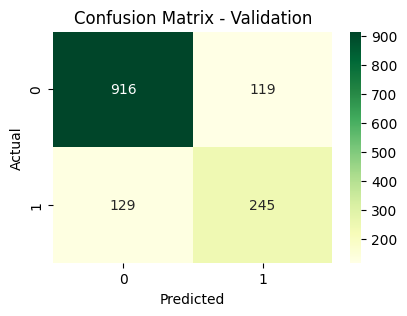

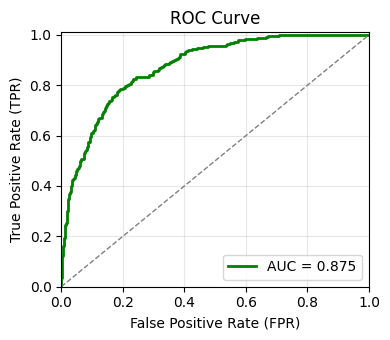

In [18]:
# Check model performance on training and validation sets
eval_model(pipe, X_train, Y_train, name="Training")
eval_model(pipe, X_val,   Y_val,   name="Validation", show_cm=True, show_roc=True)

### 2.2. Logistic Regression Tuned

In [19]:
# Build Pipeline for preprocess and model
pipe = Pipeline([
    ("preprocess", PreprocessTransformer()),
    ("model", LogisticRegression(
        max_iter=2000,
        random_state=42,
        class_weight='balanced'
    ))
])

# Execute pipeline
pipe.fit(X_train, Y_train)

Pipeline(steps=[('preprocess', PreprocessTransformer()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    random_state=42))])

In [20]:
# Predictions
Y_val_pred = pipe.predict(X_val)
Y_val_proba = pipe.predict_proba(X_val)[:, 1]

=== Training Results (threshold=0.50) ===
Precision : 0.548
Recall    : 0.835
F1 Score  : 0.662
F2 Score  : 0.756
Accuracy  : 0.774
ROC AUC   : 0.874
----------
=== Validation Results (threshold=0.50) ===
Precision : 0.519
Recall    : 0.842
F1 Score  : 0.642
F2 Score  : 0.749
Accuracy  : 0.751
ROC AUC   : 0.874
----------


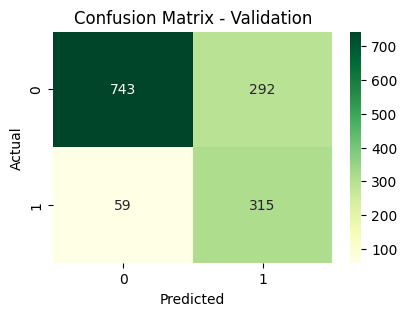

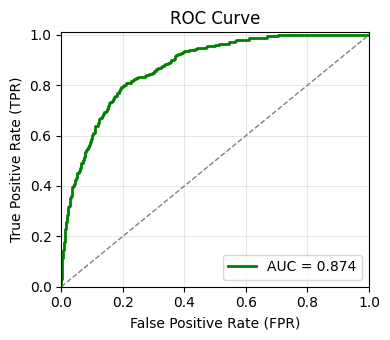

In [21]:
# Check model performance on training and validation sets
eval_model(pipe, X_train, Y_train, name="Training")
eval_model(pipe, X_val,   Y_val,   name="Validation", show_cm=True, show_roc=True)

In [22]:
def evaluate_thresholds(y_true, y_proba, thresholds):
    """
    Evaluate precision/recall/F1/F2/accuracy for multiple thresholds and
    plot precision, recall and F2 curves.
    Identifies the best threshold based on maximum F1 score.
    """
    
    # create table to check metrics for each treshold
    rows = []
    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall    = recall_score(y_true, y_pred, zero_division=0)
        f1        = f1_score(y_true, y_pred, zero_division=0)
        f2        = fbeta_score(y_true, y_pred, beta=2, zero_division=0)        
        accuracy  = accuracy_score(y_true, y_pred)

        rows.append({
            "threshold": thr,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "f2": f2,
            "accuracy": accuracy
        })

    df_thresh = pd.DataFrame(rows)

    # --- Identify the best threshold based on max F1 ---
    best_idx = df_thresh["f1"].idxmax()
    best_thr = df_thresh.loc[best_idx, "threshold"]
    best_f1  = df_thresh.loc[best_idx, "f1"]    

    # ---- Plot Precision & Recall vs Threshold ----
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(df_thresh["threshold"], df_thresh["precision"], marker="o", label="Precision")
    ax.plot(df_thresh["threshold"], df_thresh["recall"], marker="o", label="Recall")
    ax.plot(df_thresh["threshold"], df_thresh["f1"], marker="o", label="F1 Score", color="grey", linestyle="--", alpha=0.8)
    ax.plot(df_thresh["threshold"], df_thresh["f2"], marker="o", label="F2 Score")
    
    # --- Highlight the best F1 score ---
    ax.scatter(best_thr, best_f1, color="red", s=120, zorder=5, label=f"Best F1 ({best_thr:.3f})")

    ax.annotate(
        f"Max F1 = {best_f1:.3f}\nThresh = {best_thr:.3f}",
        xy=(best_thr, best_f1),
        xytext=(best_thr + 0.01, best_f1 - 0.12),
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray"),
        arrowprops=dict(arrowstyle="->", color="gray")
    )

    ax.set_title(f"Precision & Recall & F1 Score vs Threshold Value")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1.01)
    ax.set_yticks(np.arange(0, 1.01, 0.1))
    ax.legend(loc="best")
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df_thresh

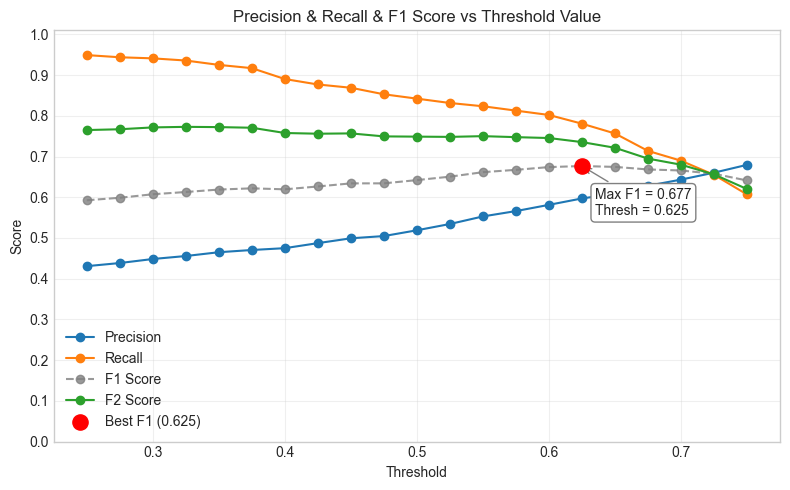

,threshold,precision,recall,f1,f2,accuracy
0,0.250,0.430825,0.949198,0.592654,0.765086,0.653655
1,0.275,0.438509,0.943850,0.598813,0.767058,0.664301
2,0.300,0.448408,0.941176,0.607420,0.771591,0.677076
3,0.325,0.455729,0.935829,0.612960,0.772968,0.686302
4,0.350,0.465054,0.925134,0.618962,0.772321,0.697658
5,0.375,0.470508,0.917112,0.621940,0.770787,0.704045
6,0.400,0.475036,0.890374,0.619535,0.757852,0.709723
7,0.425,0.487370,0.877005,0.626552,0.756109,0.722498
8,0.450,0.499232,0.868984,0.634146,0.756870,0.733854
9,0.475,0.504747,0.852941,0.634195,0.749530,0.738822


In [23]:
y_val_proba = pipe.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.25, 0.75, 21)
df_thresh = evaluate_thresholds(Y_val, y_val_proba, thresholds)
df_thresh

=== Train Results (threshold=0.62) ===
Precision : 0.614
Recall    : 0.750
F1 Score  : 0.675
F2 Score  : 0.718
Accuracy  : 0.809
ROC AUC   : 0.874
----------
=== Validation Results (threshold=0.62) ===
Precision : 0.597
Recall    : 0.781
F1 Score  : 0.677
F2 Score  : 0.736
Accuracy  : 0.802
ROC AUC   : 0.874
----------


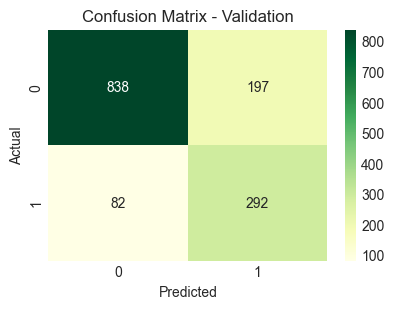

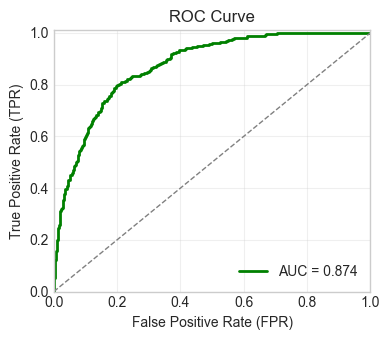

In [24]:
best_t = 0.625
# Check model performance on training and validation sets
eval_model(pipe, X_train, Y_train, name="Train", threshold=best_t)
eval_model(pipe, X_val, Y_val, name="Validation", threshold=best_t, show_cm=True, show_roc=True)

In [25]:
# Extract feature names and coefficients from the logistic regression model
logistic_model = pipe.named_steps["model"]

# get preprocessed X_val
X_val_prep = pipe.named_steps["preprocess"].transform(X_val)  # X_val is RAW (unscaled)

# build dataframe with feature names and coefficients
coef_df = pd.DataFrame({
    "feature": X_val_prep.columns,
    "coefficient": logistic_model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df

,feature,coefficient
3,Monthly Charge,1.042238
7,Senior Citizen,0.572214
5,Paperless Billing,0.302382
2,Internet Type,0.106099
11,Unlimited Data,0.037740
9,Total Extra Data Charges per Month,0.005119
10,Total Long Distance Charges per Month,-0.125810
6,Payment Method_Credit Card,-0.630201
4,Number of Referrals_bins,-0.659515
8,Tenure in Months,-0.893770


### 2.3. LightGBM

#### 2.3.1. LightGBM with treshold optimization

In [26]:
# Build Pipeline for preprocess and model
pipe = Pipeline([
    ("preprocess", PreprocessTransformer()),
    ("model", lgb.LGBMClassifier(
        objective='binary',
        random_state=42,
        class_weight='balanced'
    ))
])

# Execute pipeline
pipe.fit(X_train, Y_train)

Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não conseguiu localizar o ficheiro especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "c:\Users\pedro\Projects\telco_churn\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Py

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1121, number of negative: 3104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Pipeline(steps=[('preprocess', PreprocessTransformer()),
                ('model',
                 LGBMClassifier(class_weight='balanced', objective='binary',
                                random_state=42))])

In [27]:
# Predictions
Y_val_pred = pipe.predict(X_val)
Y_val_proba = pipe.predict_proba(X_val)[:, 1]

=== Training Results (threshold=0.50) ===
Precision : 0.751
Recall    : 0.979
F1 Score  : 0.850
F2 Score  : 0.923
Accuracy  : 0.908
ROC AUC   : 0.978
----------
=== Validation Results (threshold=0.50) ===
Precision : 0.612
Recall    : 0.824
F1 Score  : 0.702
F2 Score  : 0.770
Accuracy  : 0.815
ROC AUC   : 0.900
----------


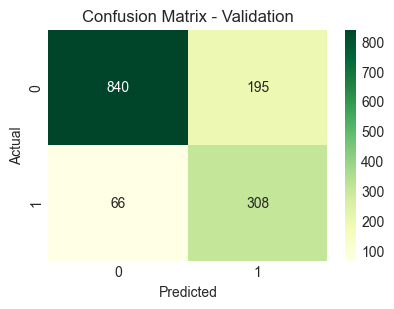

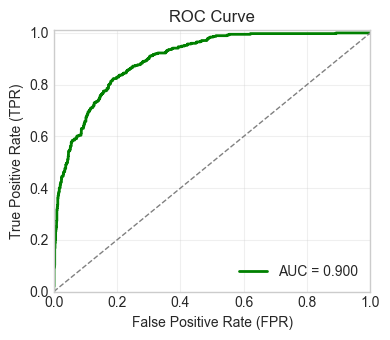

In [28]:
# Check model performance on training and validation sets
eval_model(pipe, X_train, Y_train, name="Training")
eval_model(pipe, X_val,   Y_val,   name="Validation", show_cm=True, show_roc=True)

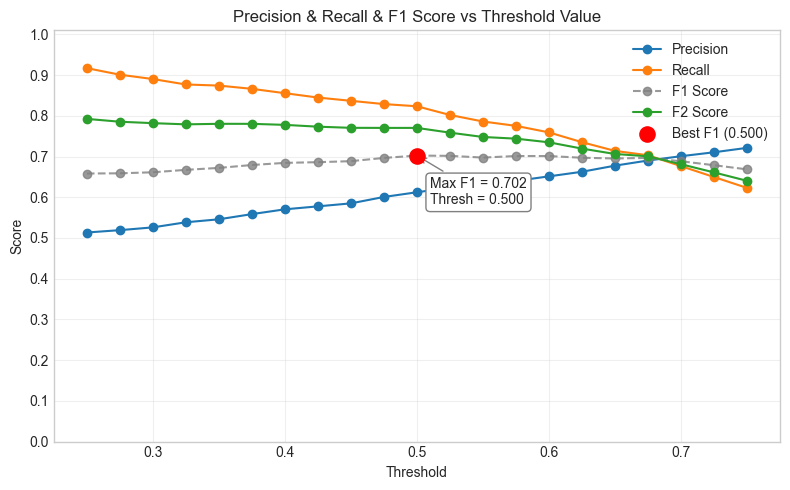

,threshold,precision,recall,f1,f2,accuracy
0,0.250,0.513473,0.917112,0.658349,0.792514,0.747339
1,0.275,0.519260,0.901070,0.658847,0.785548,0.752307
2,0.300,0.526066,0.890374,0.661370,0.782057,0.757984
3,0.325,0.538588,0.877005,0.667345,0.779097,0.767921
4,0.350,0.545910,0.874332,0.672148,0.780430,0.773598
5,0.375,0.558621,0.866310,0.679245,0.780347,0.782825
6,0.400,0.570410,0.855615,0.684492,0.777832,0.790632
7,0.425,0.577697,0.844920,0.686211,0.773372,0.794890
8,0.450,0.585047,0.836898,0.688669,0.770556,0.799148
9,0.475,0.600775,0.828877,0.696629,0.770378,0.808375


In [29]:
y_val_proba = pipe.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.25, 0.75, 21)
df_thresh = evaluate_thresholds(Y_val, y_val_proba, thresholds)
df_thresh

=== Train Results (threshold=0.50) ===
Precision : 0.751
Recall    : 0.979
F1 Score  : 0.850
F2 Score  : 0.923
Accuracy  : 0.908
ROC AUC   : 0.978
----------
=== Validation Results (threshold=0.50) ===
Precision : 0.612
Recall    : 0.824
F1 Score  : 0.702
F2 Score  : 0.770
Accuracy  : 0.815
ROC AUC   : 0.900
----------


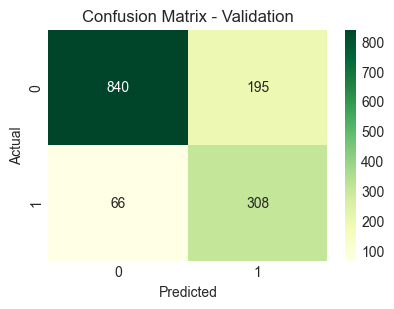

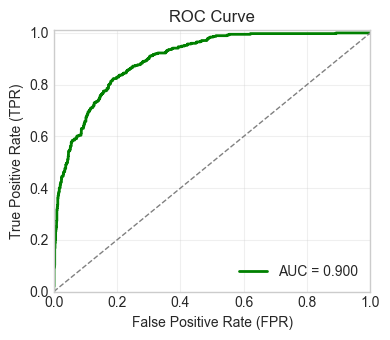

In [30]:
best_t = 0.50
# Check model performance on training and validation sets
eval_model(pipe, X_train, Y_train, name="Train", threshold=best_t)
eval_model(pipe, X_val, Y_val, name="Validation", threshold=best_t, show_cm=True, show_roc=True)

#### 2.3.2 LightGBMT TUNED with treshold optimization

In [31]:
# Fit preprocess separately to extract preprocessed data
preprocess = PreprocessTransformer()

X_train_prep = preprocess.fit_transform(X_train, Y_train)
X_val_prep   = preprocess.transform(X_val)

# Fit LightGBM model separately
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    random_state=42,
    class_weight='balanced',

    # --- regularization ---
    num_leaves=30,             # smaller tree complexity
    max_depth=5,               # shallow trees reduce overfit
    min_child_samples=35,      # avoid learning noise
    subsample=0.8,             # row sampling (bagging)
    colsample_bytree=0.8,      # feature sampling
    
    # --- boosting control ---
    n_estimators=1000,
    learning_rate=0.02,        # slower learning → smoother model

    # --- L1/L2 regularization ---
    reg_alpha=0.1,
    reg_lambda=0.3
)

lgb_model.fit(
    X_train_prep, Y_train,
    eval_set=[(X_val_prep, Y_val)],
    eval_metric='auc',
    callbacks=[
        early_stopping(100),
        log_evaluation(50)
    ]
)

# Build Pipeline for preprocess and model
pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", lgb_model),
])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1121, number of negative: 3104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 12
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [32]:
# Predictions
Y_val_pred = pipe.predict(X_val)
Y_val_proba = pipe.predict_proba(X_val)[:, 1]

=== Training Results (threshold=0.50) ===
Precision : 0.628
Recall    : 0.895
F1 Score  : 0.738
F2 Score  : 0.825
Accuracy  : 0.832
ROC AUC   : 0.932
----------
=== Validation Results (threshold=0.50) ===
Precision : 0.586
Recall    : 0.896
F1 Score  : 0.708
F2 Score  : 0.810
Accuracy  : 0.804
ROC AUC   : 0.911
----------


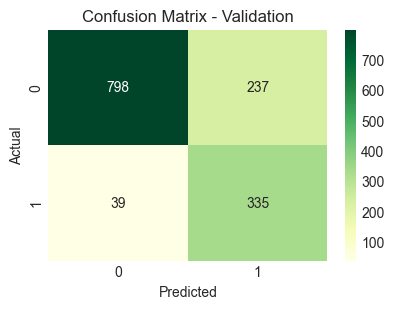

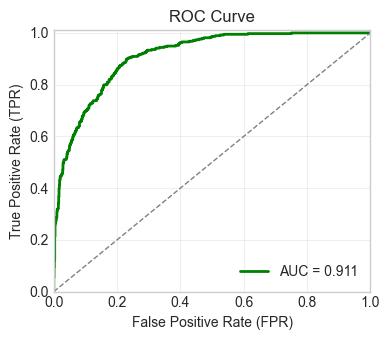

In [33]:
# Check model performance on training and validation sets
eval_model(pipe, X_train, Y_train, name="Training")
eval_model(pipe, X_val,   Y_val,   name="Validation", show_cm=True, show_roc=True)

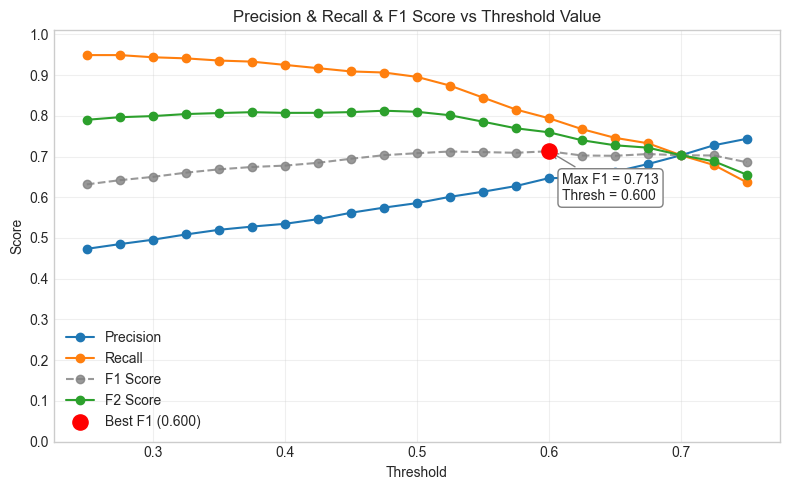

,threshold,precision,recall,f1,f2,accuracy
0,0.250,0.473333,0.949198,0.631673,0.790294,0.706175
1,0.275,0.484973,0.949198,0.641953,0.796679,0.718950
2,0.300,0.495787,0.943850,0.650092,0.799366,0.730305
3,0.325,0.508671,0.941176,0.660413,0.804388,0.743080
4,0.350,0.520059,0.935829,0.668577,0.806823,0.753726
5,0.375,0.527988,0.933155,0.674396,0.808994,0.760823
6,0.400,0.534776,0.925134,0.677767,0.807280,0.766501
7,0.425,0.546178,0.917112,0.684631,0.807439,0.775727
8,0.450,0.561983,0.909091,0.694586,0.809139,0.787793
9,0.475,0.574576,0.906417,0.703320,0.812560,0.797019


In [34]:
y_val_proba = pipe.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.25, 0.75, 21)
df_thresh = evaluate_thresholds(Y_val, y_val_proba, thresholds)
df_thresh

=== Train Results (threshold=0.60) ===
Precision : 0.697
Recall    : 0.821
F1 Score  : 0.754
F2 Score  : 0.793
Accuracy  : 0.858
ROC AUC   : 0.932
----------
=== Validation Results (threshold=0.60) ===
Precision : 0.647
Recall    : 0.794
F1 Score  : 0.713
F2 Score  : 0.760
Accuracy  : 0.830
ROC AUC   : 0.911
----------


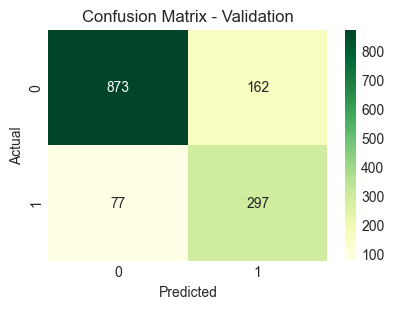

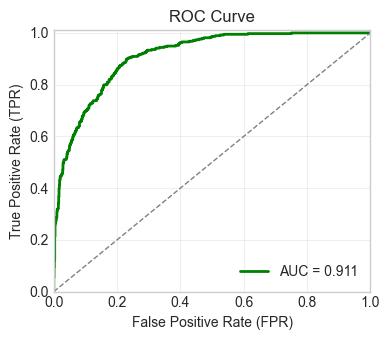

In [35]:
best_t = 0.60
# Check model performance on training and validation sets
eval_model(pipe, X_train, Y_train, name="Train", threshold=best_t)
eval_model(pipe, X_val, Y_val, name="Validation", threshold=best_t, show_cm=True, show_roc=True)

In [36]:
# Extract feature names and coefficients from the logistic regression model
lgb_model = pipe.named_steps["model"]

# check most important features --> measures how often a feature is used to split the data across all trees and how much that split reduced loss
feat_importance_df = pd.DataFrame({
    "feature": X_val_prep.columns,
    "importance": lgb_model.feature_importances_
}).sort_values(by="importance", ascending=False)

feat_importance_df

,feature,importance
3,Monthly Charge,1148
8,Tenure in Months,1107
10,Total Long Distance Charges per Month,744
4,Number of Referrals_bins,511
0,Contract Duration,343
1,Dependents,332
6,Payment Method_Credit Card,202
2,Internet Type,181
7,Senior Citizen,181
5,Paperless Billing,109


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


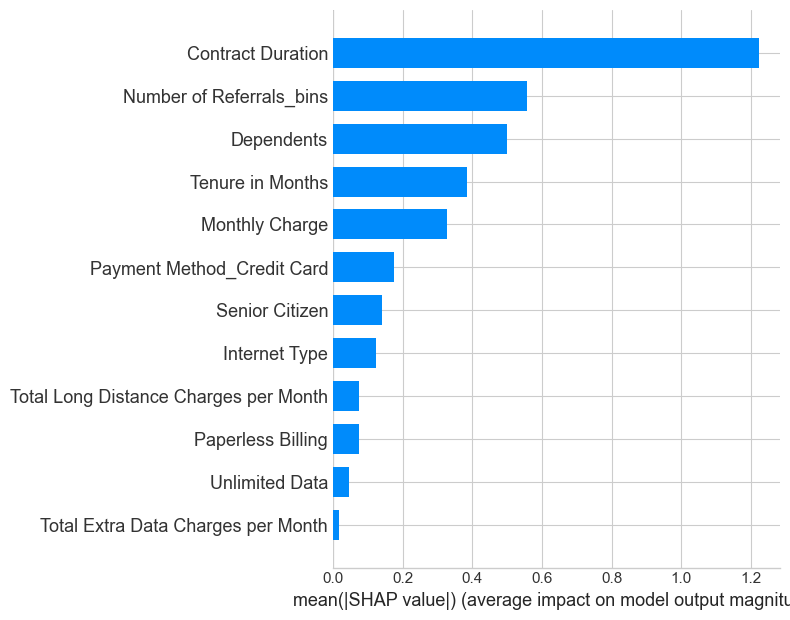

In [37]:
# Compute SHAP values for LightGBM model --> measures How much did this feature change the model’s output, on average, across samples?
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_val_prep)
shap.summary_plot(shap_values[1], X_val_prep, plot_type="bar")

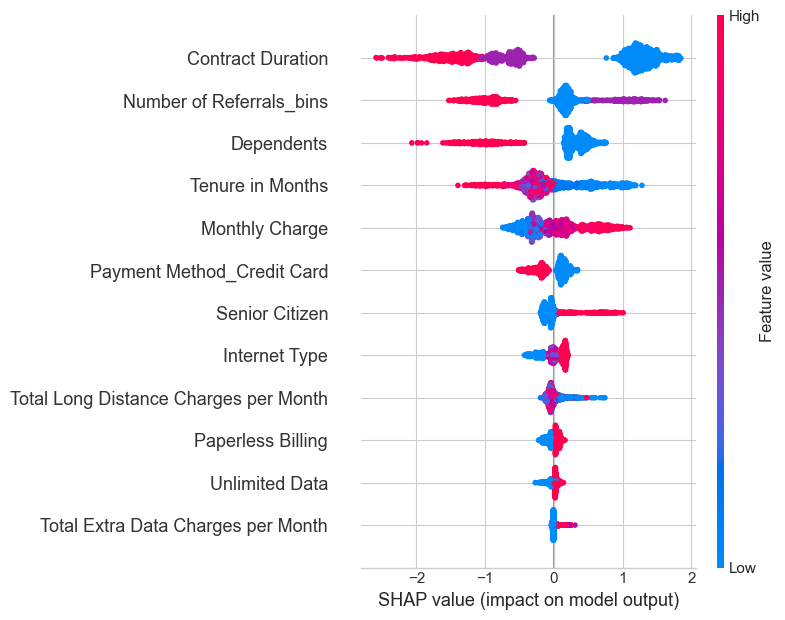

In [38]:
shap.summary_plot(shap_values[1], X_val_prep)

In [39]:
# save model as best_lgb_model.pkl
joblib.dump(pipe, "../models/best_churn_pipeline.pkl")

['../models/best_churn_pipeline.pkl']

### 2.4. Deploy best model

In [40]:
# load from initial_dfs of train, validation and test sets
train_df = pd.read_parquet(
    "../data/initial_dfs/train_df.parquet",
    engine="pyarrow"
)

val_df = pd.read_parquet(
    "../data/initial_dfs/val_df.parquet",
    engine="pyarrow"
)

test_df = pd.read_parquet(
    "../data/initial_dfs/test_df.parquet",
    engine="pyarrow"
)

# Split raw X and Y
TARGET = "Churn Value"

X_train = train_df.drop(columns=[TARGET])
Y_train = train_df[TARGET].astype(int)

X_val = val_df.drop(columns=[TARGET])
Y_val = val_df[TARGET].astype(int)

X_test = test_df.drop(columns=[TARGET])
Y_test = test_df[TARGET].astype(int)

In [41]:
# load best model from ../models/best_churn_pipeline.pkl
pipe = joblib.load("../models/best_churn_pipeline.pkl")

In [42]:
# Predictions
Y_val_pred = pipe.predict(X_val)
Y_val_proba = pipe.predict_proba(X_val)[:, 1]
Y_test_pred = pipe.predict(X_test)

=== Training Results (threshold=0.60) ===
Precision : 0.697
Recall    : 0.821
F1 Score  : 0.754
F2 Score  : 0.793
Accuracy  : 0.858
ROC AUC   : 0.932
----------
=== Validation Results (threshold=0.60) ===
Precision : 0.647
Recall    : 0.794
F1 Score  : 0.713
F2 Score  : 0.760
Accuracy  : 0.830
ROC AUC   : 0.911
----------
=== Test Results (threshold=0.60) ===
Precision : 0.654
Recall    : 0.778
F1 Score  : 0.711
F2 Score  : 0.750
Accuracy  : 0.832
ROC AUC   : 0.906
----------


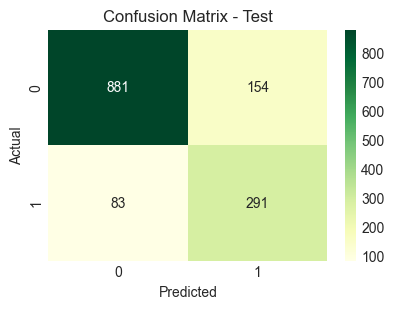

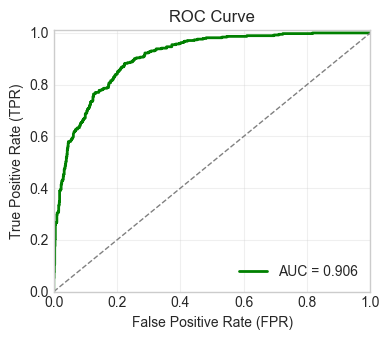

In [43]:
# Check model performance on training, validation and test sets
eval_model(pipe, X_train, Y_train, name="Training", threshold=best_t)
eval_model(pipe, X_val,   Y_val,   name="Validation", threshold=best_t)
eval_model(pipe, X_test,   Y_test,   name="Test", threshold=best_t, show_cm=True, show_roc=True)